<a href="https://colab.research.google.com/github/ssachii/pytorch-mnist/blob/main/mnist_cnn_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- All data and model operations are moved to the GPU.
- Uses a Convolutional Neural Network for higher accuracy.
- Applies transformations to the training data to improve robustness.
- Automatically adjusts the learning rate during training.
- Uses batched method for all final evaluations.
- Includes overall accuracy, a confusion matrix, a classification report, and per-class accuracy.

In [1]:
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import os

In [2]:
# configuration and parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 0.001
LR_STEP_SIZE = 3
LR_GAMMA = 0.1

Using device: cuda


In [3]:
# data loading and preprocessing with augmentation
# data augmentation for the training set to improve model robustness
transform_train = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# no augmentation for the validation/test set
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

In [4]:
 # load the full training dataset and apply transforms
full_trainset = datasets.MNIST('mnist_data', download=True, train=True, transform=transform_train)

# split the dataset into training and validation sets
train_size = int(0.9 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = torch.utils.data.random_split(full_trainset, [train_size, val_size])

# apply the non-augmented transform to the validation set
# we do this by creating a new dataset from the validation subset with the correct transform
valset.dataset.transform = transform_val

# create DataLoaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 496kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.59MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.22MB/s]


In [5]:
# model definition (convolutional neural network)
# A CNN is much more effective for image tasks than a simple MLP.
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # flatten the output for the fully connected layer
        x = self.fc_layers(x)
        return x

In [6]:
# initialization
model = SimpleCNN().to(device)

# using CrossEntropyLoss because our CNN outputs raw scores (logits).
# this loss function conveniently combines LogSoftmax and NLLLoss.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = StepLR(optimizer, step_size=LR_STEP_SIZE, gamma=LR_GAMMA)

In [7]:
# training and validation loop
print("\nStarting training...")
for e in range(EPOCHS):
    # training phase
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            val_loss += criterion(output, labels).item()
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == labels).sum().item()

    # step the scheduler
    scheduler.step()

    avg_train_loss = running_loss / len(trainloader)
    avg_val_loss = val_loss / len(valloader)
    val_accuracy = correct / len(valset)

    print(f"Epoch {e+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f} | "
          f"LR: {scheduler.get_last_lr()[0]:.6f}")

print("\nTraining finished!")


Starting training...
Epoch 1/10 | Train Loss: 0.2782 | Val Loss: 0.0958 | Val Acc: 0.9707 | LR: 0.001000
Epoch 2/10 | Train Loss: 0.0673 | Val Loss: 0.0797 | Val Acc: 0.9773 | LR: 0.001000
Epoch 3/10 | Train Loss: 0.0473 | Val Loss: 0.0671 | Val Acc: 0.9813 | LR: 0.000100
Epoch 4/10 | Train Loss: 0.0297 | Val Loss: 0.0525 | Val Acc: 0.9853 | LR: 0.000100
Epoch 5/10 | Train Loss: 0.0269 | Val Loss: 0.0539 | Val Acc: 0.9855 | LR: 0.000100
Epoch 6/10 | Train Loss: 0.0257 | Val Loss: 0.0518 | Val Acc: 0.9863 | LR: 0.000010
Epoch 7/10 | Train Loss: 0.0234 | Val Loss: 0.0510 | Val Acc: 0.9857 | LR: 0.000010
Epoch 8/10 | Train Loss: 0.0230 | Val Loss: 0.0510 | Val Acc: 0.9855 | LR: 0.000010
Epoch 9/10 | Train Loss: 0.0229 | Val Loss: 0.0512 | Val Acc: 0.9857 | LR: 0.000001
Epoch 10/10 | Train Loss: 0.0226 | Val Loss: 0.0512 | Val Acc: 0.9857 | LR: 0.000001

Training finished!



--- Final Model Evaluation ---


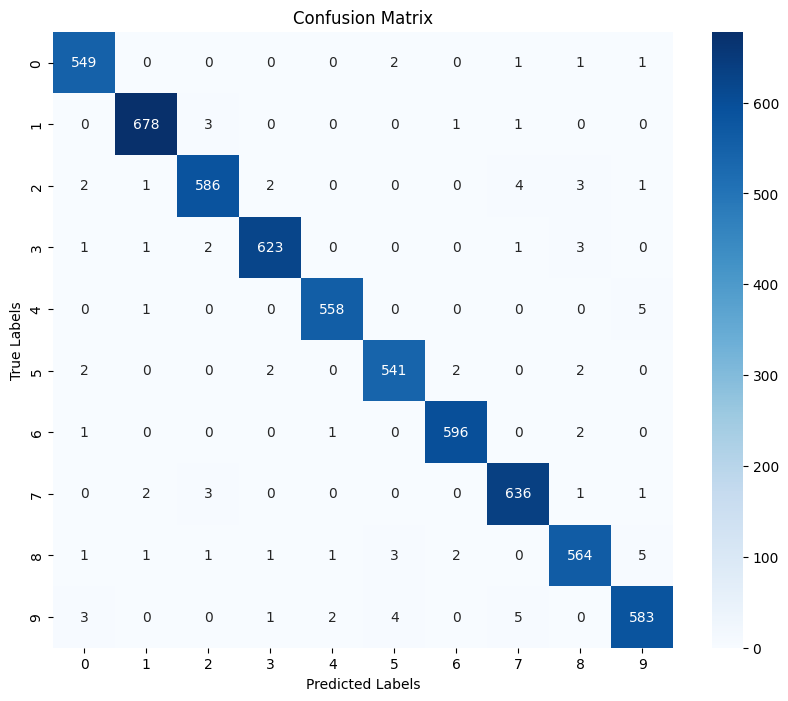


Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       554
           1       0.99      0.99      0.99       683
           2       0.98      0.98      0.98       599
           3       0.99      0.99      0.99       631
           4       0.99      0.99      0.99       564
           5       0.98      0.99      0.98       549
           6       0.99      0.99      0.99       600
           7       0.98      0.99      0.99       643
           8       0.98      0.97      0.98       579
           9       0.98      0.97      0.98       598

    accuracy                           0.99      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       0.99      0.99      0.99      6000


Per-Class Accuracy:

Accuracy for digit 0: 0.9910
Accuracy for digit 1: 0.9927
Accuracy for digit 2: 0.9783
Accuracy for digit 3: 0.9873
Accuracy for digit 4: 0.9894
Accuracy for digit 5: 0.9854
Accuracy for digit 6

In [8]:
# final evaluation on validation set
print("\n--- Final Model Evaluation ---")
model.eval()
true_labels = []
pred_labels = []

with torch.no_grad():
    for images, labels in valloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

# confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# classification report
print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels))

# per-class accuracy
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print("\nPer-Class Accuracy:\n")
for i, acc in enumerate(per_class_accuracy):
    print(f"Accuracy for digit {i}: {acc:.4f}")

In [12]:
# inference on custom user images
# define a specific transform pipeline for user images that INCLUDES resizing (for images that are not 28x28)
transform_user = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

def preprocess_user_image(image_path, transform):
    # loads and preprocesses a single user image
    try:
        user_image = Image.open(image_path).convert("L")  # convert to grayscale
        return transform(user_image).unsqueeze(0) # apply transform and add batch dimension
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

def predict_user_image(image_tensor, model):
    # makes a prediction on a preprocessed image tensor
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        output = model(image_tensor)
        _, predicted = torch.max(output.data, 1)
    return predicted.item()




--- Testing on images in 'my_images' folder ---
Image: mnist_3.jpeg, Predicted Digit: 3


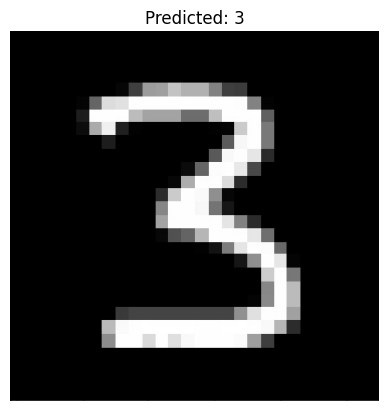

In [15]:
# create a folder 'my_images' in Colab and upload your digit images there
image_folder = 'my_images'
if os.path.isdir(image_folder):
    print(f"\n--- Testing on images in '{image_folder}' folder ---")
    for image_file in os.listdir(image_folder):
        user_image_path = os.path.join(image_folder, image_file)
        if os.path.isfile(user_image_path):
            # use the transform pipeline with the resize step
            user_tensor = preprocess_user_image(user_image_path, transform_user)

            if user_tensor is not None:
                prediction = predict_user_image(user_tensor, model)
                print(f"Image: {image_file}, Predicted Digit: {prediction}")

                # display the image
                display_img = Image.open(user_image_path)
                plt.imshow(display_img, cmap='gray')
                plt.title(f"Predicted: {prediction}")
                plt.axis('off')
                plt.show()
else:
    print(f"\nTo test your own images, create a folder named '{image_folder}' and upload your files.")